# Plot

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import sys
import glob

delphesDir = os.path.abspath("../../DelphesLLP")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT
import xml.etree.ElementTree as ET


ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

sys.path.append('../../')
sys.path.append('../../ATLAS-SUSY-2016-08')
from helper import getLLPs,getJets,getModelDict
from atlas_susy_2016_08_Recast import eventAcc,vertexAcc,eventEff


pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

colors = sns.color_palette('Paired')

Welcome to JupyROOT 6.24/06


### Load Recast Data

In [2]:
inputFiles = list(glob.glob('../../eventData/pp2BB1j_atlas_scan_New/Events/run_*/cdfo_481_450.0_tau_3e-02_delphes_events.root'))
modelDict = getModelDict(inputFiles[0],model='sbottom')
title = r'$m_{\tilde b} = %1.0f$ GeV, $m_{\tilde \chi_1^0} = %1.0f$ GeV, $\tau = %1.2f$ ns'%(modelDict['mLLP'],modelDict['mLSP'],modelDict['tau_ns'])
figlabel = 'msb_%1.0f_mchi_%1.0f_tau_%1.2f'%(modelDict['mLLP'],modelDict['mLSP'],modelDict['tau_ns'])

mLLP =  481.38
width (GeV) =  2.309474e-14
tau (ns) =  0.028499996103008733


In [3]:
pTj1 = []
pTj2 = []
mDV_nTracks = []
mDV_nTracks_cuts = []
njets = []
met = []
weights = []
ntotal = 0
lumi = 1.0
totalweightPB = 0.0
ntotal = 0
for inputFile in inputFiles:
    f = ROOT.TFile(inputFile,'read')
    tree = f.Get("Delphes")
    nevts = tree.GetEntries()
    ntotal += nevts
    f.Close()


for inputFile in inputFiles:
    f = ROOT.TFile(inputFile,'read')
    tree = f.Get("Delphes")
    nevts = tree.GetEntries()
    norm = nevts/ntotal

    for ievt in range(nevts):
        tree.GetEntry(ievt)   
        weightPB = tree.Weight.At(1).Weight*norm     
        totalweightPB += weightPB
        ns = weightPB*1e3*lumi # number of signal events
        
        llps = getLLPs(tree.bsm,tree.bsmDirectDaughters,tree.bsmFinalDaughters,trackEff=1.0)
        jets = getJets(tree.GenJet,pTmin=25.,etaMax=5.0)
        jets = sorted(jets, key = lambda j: j.PT, reverse=True)

        njets.append(len(jets))
        pt1 = 0.0
        pt2 = 0.02
        if len(jets) > 0:
            pt1 = jets[0].PT
        if len(jets) > 1:
            pt2 = jets[1].PT
        pTj1.append(pt1)
        pTj2.append(pt2)
        missET = tree.GenMissingET.At(0).MET
        met.append(missET)
        weights.append(ns)
        for llp in llps:
            mDV_nTracks.append([llp.mDV,llp.nTracks,ns])

        # Apply cuts acceptance
        evt_acc = eventAcc(jets,missET,metCut=200.0,
                               maxJetChargedPT=5.0,minJetPt1=70.,
                               minJetPt2=25.)

        if (not evt_acc):
            continue

        ns = ns*evt_acc
        # Vertex acceptances:
        v_acc = np.array([vertexAcc(llp,Rmax=300.0,zmax=300.0,Rmin=4.0,
                                    d0min=2.0,nmin=0,mDVmin=0.0)  for llp in llps])
        good_llps = np.array(llps)[v_acc > 0.0]
        if len(good_llps) == 0:
            continue
        # Event efficiency
        evt_eff = eventEff(missET,good_llps)
        if evt_eff <=0.0:
            continue
        ns = ns*evt_eff
        for llp in good_llps:
            mDV_nTracks_cuts.append([llp.mDV,llp.nTracks,ns])
    f.Close()
            

In [19]:
print(totalweightPB)

0.49671596170810517


### Plot Jet Distributions

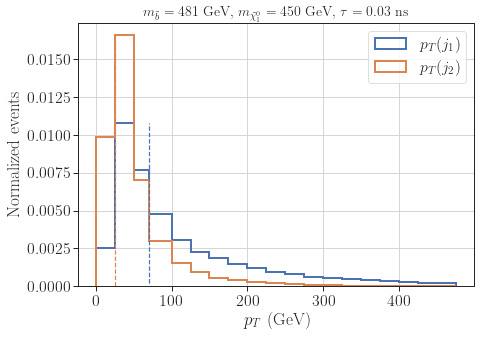

In [5]:
colors = sns.color_palette('deep')
fig = plt.figure(figsize=(7,5))
pTbins = np.append(np.array([0.,25.,50.,70.]),np.arange(100.,500.,25.))
h1,_,_ = plt.hist(pTj1,weights=weights,label=r'$p_{T}(j_1)$',histtype='step',
                  linewidth=2,bins=pTbins,density=True,color=colors[0])
h2,_,_ = plt.hist(pTj2,weights=weights,label=r'$p_{T}(j_2)$',histtype='step',
                  linewidth=2,bins=pTbins,density=True,color=colors[1])
plt.vlines(x=70.,ymin=h1.min(),ymax=h1.max(),linestyle = 'dashed', color=colors[0])
plt.vlines(x=25.,ymin=h2.min(),ymax=h2.max(),linestyle = 'dashed', color=colors[1])
plt.legend()
# plt.yscale('log')
plt.grid()

plt.xlabel(r'$p_T$ (GeV)')
plt.ylabel('Normalized events')

# plt.title(r'$m_T = %1.0f$ GeV, $m_{\chi} = %1.0f$ GeV, $y_{DM} = %1.0f$' %(mST,mChi,yDM),loc='left')
plt.title(title,fontsize=14)
plt.tight_layout()
plt.savefig('jetPTs_%s.png' %figlabel)
plt.show()

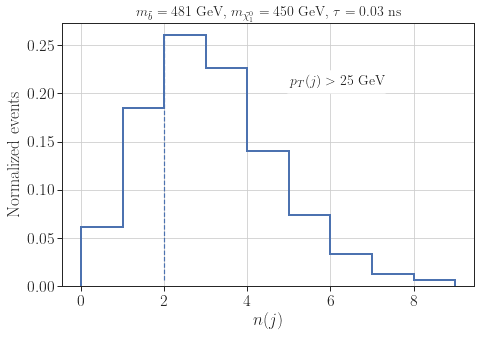

In [6]:
fig = plt.figure(figsize=(7,5))
njBins = np.arange(0.,10.,1.)
h1,b,_ = plt.hist(njets,weights=weights,histtype='step',linewidth=2,
         bins=njBins,density=True,color=colors[0])
plt.vlines(x=2.,ymin=h1.min(),ymax=h1.max(),linestyle = 'dashed', color=colors[0])
plt.grid()
plt.text(b[-5],0.8*h1.max(),r'$p_T(j) > 25$ GeV',fontsize=14,bbox={'boxstyle':'round', 'facecolor':'white'})
plt.xlabel(r'$n(j)$')
plt.ylabel('Normalized events')
plt.title(title,fontsize=14)
plt.tight_layout()
plt.savefig('njet_%s.png' %figlabel)
plt.show()

### Plot MET

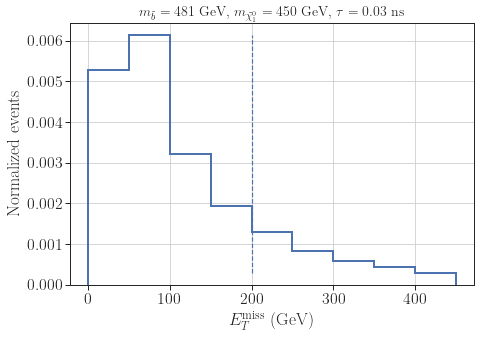

In [7]:
fig = plt.figure(figsize=(7,5))
metBins = np.arange(0.,500.,50.)
h1,_,_ = plt.hist(met,weights=weights,histtype='step',linewidth=2,
         bins=metBins,density=True,color=colors[0])
plt.vlines(x=200.,ymin=h1.min(),ymax=h1.max(),linestyle = 'dashed', color=colors[0])
plt.grid()

plt.xlabel(r'$E_{T}^{\rm miss}$ (GeV)')
plt.ylabel('Normalized events')
plt.title(title,fontsize=14)
plt.tight_layout()
plt.savefig('met_%s.png' %figlabel)
plt.show()

### Plot mDV and nTracks dist

In [8]:
mDV_nTracks_weights = np.array(mDV_nTracks)
data_obs = np.genfromtxt('../../ATLAS-SUSY-2016-08/ATLAS_data/HEPData-ins1630632-v2-csv/Table6.csv',
                         delimiter=',',skip_header=11,skip_footer=113)
data_exp = np.genfromtxt('../../ATLAS-SUSY-2016-08/ATLAS_data/HEPData-ins1630632-v2-csv/Table6.csv',
                         delimiter=',',skip_header=126)

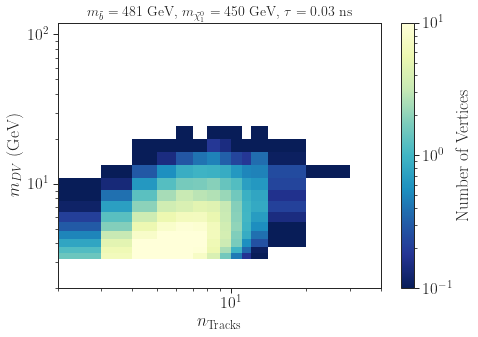

In [18]:
fig = plt.figure(figsize=(7,5))
cm = plt.colormaps['YlGnBu_r']
mDV_bins = np.sort(np.unique(data_exp[:,1]))
n_bins = np.sort((np.unique(data_exp[:,0])))
# mDV_bins = np.append(mDV_bins,np.arange(200.,1000.,100.))
n_bins = np.append(np.unique(data_exp[:,0]),[20.,30.,40.])
h = plt.hist2d(mDV_nTracks_weights[:,1],mDV_nTracks_weights[:,0],cmap=cm,
               weights=mDV_nTracks_weights[:,2],bins=(n_bins,mDV_bins),norm=LogNorm(vmin=1e-1,vmax=10))


# for ipt,pt in enumerate(data_obs):
#     if pt[-1] == 0.0:
#         continue
#     plt.text(1.1*pt[0],pt[1],'%i' %pt[-1],fontsize=10)
    
# plt.hlines(y=10.0,xmin=5.,xmax=max(n_bins),colors='red',linestyle='dashed')
# plt.vlines(x=5.0,ymin=10.,ymax=max(mDV_bins),colors='red',linestyle='dashed')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$m_{DV}$ (GeV)')
plt.xlabel(r'$n_{\rm Tracks}$')
plt.ylim(2,120.)
plt.xlim(2,40)
fig.colorbar(h[3], ax=plt.gca(),label='Number of Vertices')
plt.title(title,fontsize=14)
plt.tight_layout()
plt.savefig('mDVnTrack_%s.png' %figlabel)
plt.show()

### Plot mDV and nTracks dist after pre-selection

In [10]:
mDV_nTracks_weights_cut = np.array(mDV_nTracks_cuts)

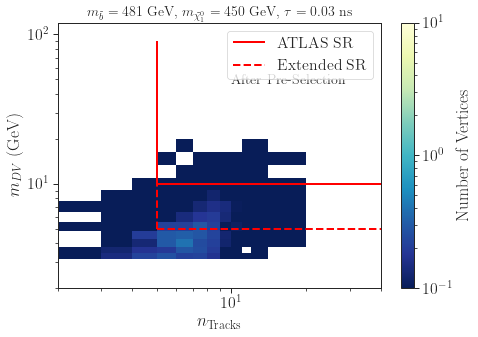

In [17]:
fig = plt.figure(figsize=(7,5))
cm = plt.colormaps['YlGnBu_r']
mDV_bins = np.sort(np.unique(data_exp[:,1]))
n_bins = np.sort((np.unique(data_exp[:,0])))
# mDV_bins = np.append(mDV_bins,np.arange(200.,1000.,100.))
n_bins = np.append(np.unique(data_exp[:,0]),[20.,30.,40.])
h = plt.hist2d(mDV_nTracks_weights_cut[:,1],mDV_nTracks_weights_cut[:,0],cmap=cm,
               weights=mDV_nTracks_weights_cut[:,2],bins=(n_bins,mDV_bins),norm=LogNorm(vmin=1e-1,vmax=10))


# for ipt,pt in enumerate(data_obs):
#     if pt[-1] == 0.0:
#         continue
#     plt.text(1.1*pt[0],pt[1],'%i' %pt[-1],fontsize=10)

plt.text(n_bins[-int(len(n_bins)/2)],mDV_bins[-4],"After Pre-Selection",fontsize=14)
plt.hlines(y=10.0,xmin=5.,xmax=max(n_bins),colors='red',linestyle='solid',label='ATLAS SR',linewidth=2)
plt.vlines(x=5.0,ymin=10.,ymax=max(mDV_bins),colors='red',linestyle='solid',linewidth=2)

plt.hlines(y=5.0,xmin=5.,xmax=max(n_bins),colors='red',linestyle='dashed',label='Extended SR',linewidth=2)
plt.vlines(x=5.0,ymin=5.,ymax=max(mDV_bins),colors='red',linestyle='dashed',linewidth=2)

plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$m_{DV}$ (GeV)')
plt.xlabel(r'$n_{\rm Tracks}$')
plt.ylim(2,120.)
plt.xlim(2,40)
fig.colorbar(h[3], ax=plt.gca(),label='Number of Vertices')
plt.title(title,fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig('mDVnTrackCut_%s.png' %figlabel)
plt.show()